<a href="https://colab.research.google.com/github/danplotkin/DCGAN_PyTorch/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will be implementing a Deep Convolutional Generative Adversarial Network (DCGAN) based on the [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) paper by Radford et. al. Unlike basic GANs, DCGANs incorporates deep convolutional neural networks (CNNs) in both the generator and discriminator. Let us look at a visualization of a DCGAN.

![image](https://raw.githubusercontent.com/danplotkin/DCGAN_PyTorch/main/DCGAN_architecture.png)

### Generator

The generator in a DCGAN is responsible for transforming random noise vectors into images. It takes in a random noise vector, denoted by $z$, which will follow a normal distribution. The main building block to the generator are transposed convolutional layers. These are also known as upsampling or deconvolutional layers. Every upsampling layer is followed by a Batch Normalization layer, and a ReLU activation function, except the last upsampling layer. After the last upsampling layer, the output is fed into the hyperbolic tangent (Tanh) which maps the output range to [-1, 1], which is what we want our pixel values for our image to be.

### Discriminator

The goal of the discriminator in a DCGAN it to discriminate between real and fake data samples created by the generator. The generator tries to generate samples that can fool the discriminator into classifying them as real. The discriminator takes in images channels as input. The building blocks to a discriminator are convolutional layers. Every convlutional layer is followed by a Batch Normalization layer and a Leaky ReLU except the first and last convolutional layers. The first convolutional layer is followed by a Leaky ReLU activation, with no Batch Normalization. The last convolutional layer is followed by a Sigmoid activation, mapping the output to a probability range of [0, 1].

### Network Interaction

The generator and discriminator interact with each other through an adversarial training process. The discriminator andd generator are first initialized with random weights. The generator will generate fake images with random noise vectors as input. These generated images will be fed as input into the discriminator. The discriminator will recieve both fake (from the generator) and real images (from the training data). It will learn to classify these as real or fake images. It does this through backpropagation. The loss from the discriminator is used as feedback to update the generator's weights.

Below is an image from [this blog](https://sthalles.github.io/intro-to-gans/) showing a representation of the adverserial network:

![image](https://raw.githubusercontent.com/danplotkin/DCGAN_PyTorch/main/adverserial%20network.png)

# Import Libraries

In [1]:
import os
import random
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

from google.colab import drive
drive.mount('drive/')

Mounted at drive/


# Unzip Data

In [2]:
os.environ['IOPUB_DATA_RATE_LIMIT'] = '1e10'

In [3]:
!mkdir dataset

In [ ]:
!unzip /content/drive/MyDrive/Datasets/img_align_celeba.zip -d dataset

# Define Configurations

In [5]:
class Config:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    lr = 2e-4
    batch_size = 128
    img_size = 64
    n_channels = 3
    z_dim = 100
    num_epochs = 30
    n_features = 64
    betas = (0.5, 0.999) # Defined in paper for Adam optimizer

# Preprocess Data

### Define Transformations

In [6]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((Config.img_size, Config.img_size), antialias=True),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### Load in Dataset

In [7]:
dataset = ImageFolder('dataset/', transform=transforms)

### Create DataLoader

In [8]:
data_loader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

In [9]:
data_loader.__len__()

1583

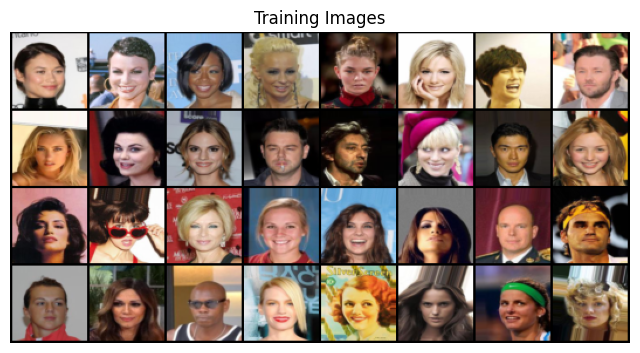

In [10]:
# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(Config.device)[:32], padding=2, normalize=True
            ).cpu(),(1,2,0)
    )
)
plt.show()

# Initlialize Weights

In [11]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, n_channels, n_features):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self._block(z_dim, n_features*8, 4, 1, 0),
            self._block(n_features*8, n_features*4, 4, 2, 1),
            self._block(n_features*4, n_features*2, 4, 2, 1),
            self._block(n_features*2, n_features, 4, 2, 1),
            nn.ConvTranspose2d(n_features, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

    def _block(self,
               in_channels,
               out_channels,
               kernel_size,
               stride,
               padding,
               bias=False):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

# Define Descriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, n_channels, n_features):
        super(Discriminator, self).__init__()
        self.descriminator = nn.Sequential(
            nn.Conv2d(n_channels, n_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            self._block(n_features, n_features*2, 4, 2, 1),
            self._block(n_features*2, n_features*4, 4, 2, 1),
            self._block(n_features*4, n_features*8, 4, 2, 1),
            nn.Conv2d(n_features*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.descriminator(x)

    def _block(self,
               in_channels,
               out_channels,
               kernel_size,
               stride,
               padding,
               bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

### Define Parameters

In [14]:
# define models
gen = Generator(Config.z_dim, Config.n_channels, Config.n_features)\
  .to(Config.device)\
  .apply(initialize_weights)
disc = Discriminator(Config.n_channels, Config.n_features)\
  .to(Config.device)\
  .apply(initialize_weights)

# define optimizers
optim_gen = optim.Adam(gen.parameters(),
                       lr=Config.lr,
                       betas=Config.betas)
optim_disc = optim.Adam(disc.parameters(),
                        lr=Config.lr,
                        betas=Config.betas)

# define criterion
criterion = nn.BCELoss()

In [15]:
print(gen, '\n', '*'*100, '\n', disc)

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(64, 3, 

# Define Functional Class

We will create a class for our DCGAN than will train, generate images, and plot training image animations.

In [16]:
class DCGAN:
    def __init__(self, disc, gen, optim_disc, optim_gen, configs, dataloader, criterion):
        self.configs = configs
        self.data_loader = dataloader
        self.optim_gen = optim_gen
        self.optim_disc = optim_disc
        self.gen = gen
        self.disc = disc
        self.criterion = criterion
        self.img_list = []
        self.fixed_noise = torch.randn(32, configs.z_dim, 1, 1).to(configs.device)
        self.history = {"G": [], "D": []}

    @torch.no_grad()
    def __call__(self, input_noise):
        self.gen.eval()
        return self.gen(input_noise).detach().cpu()

    def train(self):
        for epoch in range(self.configs.num_epochs):
            print(f'Epoch: {epoch+1}/{self.configs.num_epochs}')
            d_running_loss = 0.0
            g_running_loss = 0.0
            self.disc.train()
            self.gen.train()
            pbar = tqdm(enumerate(self.data_loader), total=len(self.data_loader))
            for i, (real_images, _) in pbar:
                batch_size = real_images.size(0)
                real_images = real_images.to(self.configs.device)
                real_labels = torch.ones(batch_size,).to(self.configs.device)
                fake_labels = torch.zeros(batch_size,).to(self.configs.device)

                # Train discriminator with real images
                self.optim_disc.zero_grad()
                real_output = self.disc(real_images).view(-1)
                d_loss_real = self.criterion(real_output, real_labels)
                d_loss_real.backward()

                # Train discriminator with fake images
                z = torch.randn(batch_size, self.configs.z_dim, 1, 1).to(self.configs.device)
                fake_images = self.gen(z)
                fake_output = self.disc(fake_images.detach()).view(-1)
                d_loss_fake = self.criterion(fake_output, fake_labels)
                d_loss_fake.backward()

                # Update discriminator parameters
                d_loss = d_loss_real + d_loss_fake
                self.optim_disc.step()
                d_running_loss += d_loss.item()

                # Update Generator Network
                self.optim_gen.zero_grad()
                output = self.disc(fake_images).view(-1)
                g_loss = self.criterion(output, real_labels)
                g_loss.backward()
                self.optim_gen.step()
                g_running_loss += g_loss.item()

                # Update logger
                d_step_loss = d_running_loss / (i+1)
                g_step_loss = g_running_loss / (i+1)

                self.history["D"].append(d_loss.item())
                self.history["G"].append(g_loss.item())

                pbar.set_description(f'Batch {i+1}/{len(self.data_loader)} - Loss_d: {d_step_loss:.4f}, Loss_g: {g_step_loss:.4f}')

            if (epoch+1) % 5 == 0 or (epoch+1) == 1:
                self._generate_with_fixed_noise()

        return self.history

    @torch.no_grad()
    def _generate_with_fixed_noise(self):
        self.gen.eval()
        fake = self.gen(self.fixed_noise).detach().cpu()
        self.img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    def plot_progression(self, figsize=(8, 8)):
        fig = plt.figure(figsize=figsize)
        plt.axis("off")
        imgs = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in self.img_list]
        ani = anim.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
        plt.close()
        return HTML(ani.to_jshtml())

# Train DCGAN

We will train our network for 50 epochs.

In [17]:
net = DCGAN(
    disc,
    gen,
    optim_disc,
    optim_gen,
    Config,
    data_loader,
    criterion
)

history = net.train()

Epoch: 1/30


Batch 1583/1583 - Loss_d: 0.6236, Loss_g: 5.4217: 100%|██████████| 1583/1583 [11:11<00:00,  2.36it/s]


Epoch: 2/30


Batch 1583/1583 - Loss_d: 0.6426, Loss_g: 3.5497: 100%|██████████| 1583/1583 [10:26<00:00,  2.53it/s]


Epoch: 3/30


Batch 1583/1583 - Loss_d: 0.7432, Loss_g: 2.7341: 100%|██████████| 1583/1583 [10:17<00:00,  2.56it/s]


Epoch: 4/30


Batch 1583/1583 - Loss_d: 0.7885, Loss_g: 2.5076: 100%|██████████| 1583/1583 [10:16<00:00,  2.57it/s]


Epoch: 5/30


Batch 1583/1583 - Loss_d: 0.7813, Loss_g: 2.4665: 100%|██████████| 1583/1583 [10:14<00:00,  2.58it/s]


Epoch: 6/30


Batch 1583/1583 - Loss_d: 0.7227, Loss_g: 2.5896: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 7/30


Batch 1583/1583 - Loss_d: 0.6611, Loss_g: 2.7479: 100%|██████████| 1583/1583 [10:19<00:00,  2.56it/s]


Epoch: 8/30


Batch 1583/1583 - Loss_d: 0.6283, Loss_g: 2.8550: 100%|██████████| 1583/1583 [10:14<00:00,  2.58it/s]


Epoch: 9/30


Batch 1583/1583 - Loss_d: 0.5793, Loss_g: 2.9798: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 10/30


Batch 1583/1583 - Loss_d: 0.5705, Loss_g: 3.0808: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 11/30


Batch 1583/1583 - Loss_d: 0.5086, Loss_g: 3.2301: 100%|██████████| 1583/1583 [10:21<00:00,  2.55it/s]


Epoch: 12/30


Batch 1583/1583 - Loss_d: 0.5014, Loss_g: 3.3630: 100%|██████████| 1583/1583 [10:16<00:00,  2.57it/s]


Epoch: 13/30


Batch 1583/1583 - Loss_d: 0.4042, Loss_g: 3.5917: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 14/30


Batch 1583/1583 - Loss_d: 0.4195, Loss_g: 3.7306: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 15/30


Batch 1583/1583 - Loss_d: 0.3624, Loss_g: 3.8243: 100%|██████████| 1583/1583 [10:17<00:00,  2.56it/s]


Epoch: 16/30


Batch 1583/1583 - Loss_d: 0.4696, Loss_g: 3.7091: 100%|██████████| 1583/1583 [10:15<00:00,  2.57it/s]


Epoch: 17/30


Batch 1583/1583 - Loss_d: 0.3463, Loss_g: 3.9943: 100%|██████████| 1583/1583 [10:17<00:00,  2.56it/s]


Epoch: 18/30


Batch 1583/1583 - Loss_d: 0.3326, Loss_g: 4.1726: 100%|██████████| 1583/1583 [10:16<00:00,  2.57it/s]


Epoch: 19/30


Batch 1583/1583 - Loss_d: 0.3624, Loss_g: 4.0897: 100%|██████████| 1583/1583 [10:19<00:00,  2.56it/s]


Epoch: 20/30


Batch 1583/1583 - Loss_d: 0.3019, Loss_g: 4.3299: 100%|██████████| 1583/1583 [10:19<00:00,  2.55it/s]


Epoch: 21/30


Batch 1583/1583 - Loss_d: 0.3236, Loss_g: 4.3710: 100%|██████████| 1583/1583 [10:20<00:00,  2.55it/s]


Epoch: 22/30


Batch 1583/1583 - Loss_d: 0.3977, Loss_g: 4.2589: 100%|██████████| 1583/1583 [10:21<00:00,  2.55it/s]


Epoch: 23/30


Batch 1583/1583 - Loss_d: 0.3337, Loss_g: 4.2684: 100%|██████████| 1583/1583 [10:28<00:00,  2.52it/s]


Epoch: 24/30


Batch 1583/1583 - Loss_d: 0.3068, Loss_g: 4.4241: 100%|██████████| 1583/1583 [10:31<00:00,  2.51it/s]


Epoch: 25/30


Batch 1583/1583 - Loss_d: 0.2541, Loss_g: 4.6453: 100%|██████████| 1583/1583 [10:38<00:00,  2.48it/s]


Epoch: 26/30


Batch 1583/1583 - Loss_d: 0.2997, Loss_g: 4.6053: 100%|██████████| 1583/1583 [10:08<00:00,  2.60it/s]


Epoch: 27/30


Batch 1583/1583 - Loss_d: 0.2754, Loss_g: 4.6696: 100%|██████████| 1583/1583 [10:01<00:00,  2.63it/s]


Epoch: 28/30


Batch 1583/1583 - Loss_d: 0.3336, Loss_g: 4.6732: 100%|██████████| 1583/1583 [10:08<00:00,  2.60it/s]


Epoch: 29/30


Batch 1583/1583 - Loss_d: 0.2127, Loss_g: 4.8859: 100%|██████████| 1583/1583 [10:23<00:00,  2.54it/s]


Epoch: 30/30


Batch 1583/1583 - Loss_d: 0.2514, Loss_g: 4.9324: 100%|██████████| 1583/1583 [10:17<00:00,  2.56it/s]


# Results

### Plot Training Loss

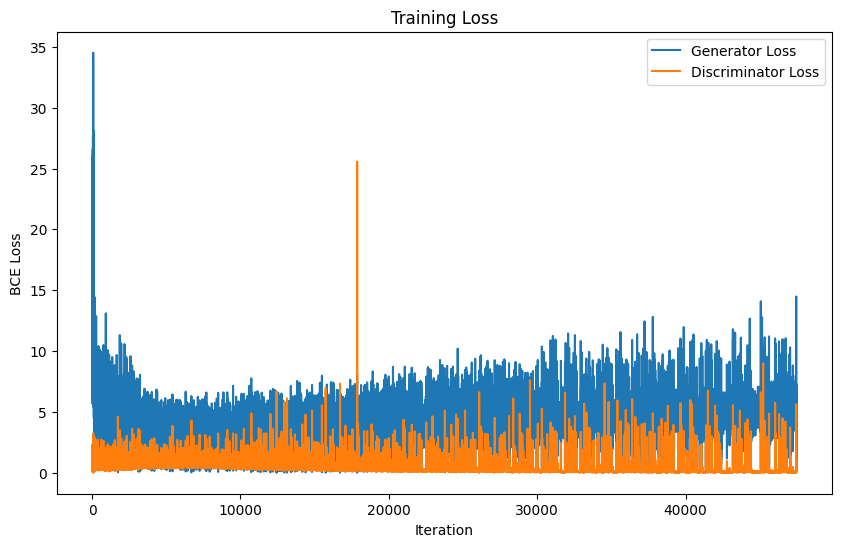

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history['G'], label='Generator Loss')
plt.plot(history['D'], label='Discriminator Loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('BCE Loss')
plt.title('Training Loss')
plt.show()

### Training Progress

Below we will plot training progression of images as an animation for every 5th epoch. Press play to view the progression of the images!

In [19]:
net.plot_progression()

# Generate Synthetic Images

Below we will generate a grid of synthetic images with our trained DCGAN.

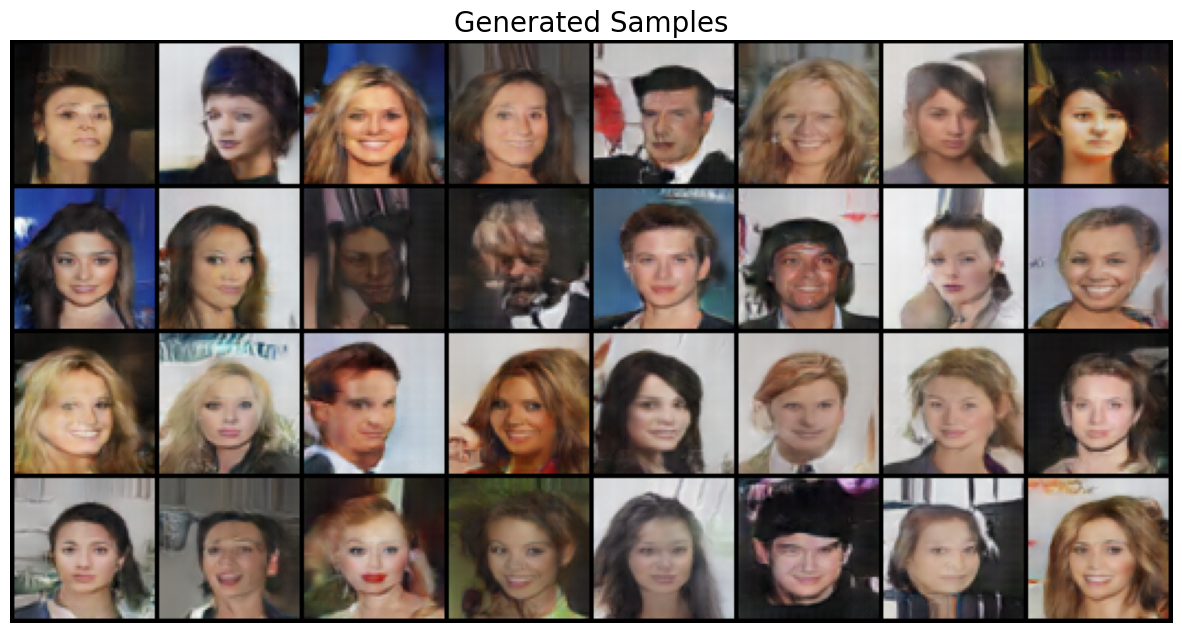

In [20]:
plt.figure(figsize=(15, 15))
noise = torch.randn(32, Config.z_dim, 1, 1).to(Config.device)
imgs = net(noise)
imgs = vutils.make_grid(imgs, padding=2, normalize=True)
plt.imshow(np.transpose(imgs, (1, 2, 0)), animated=True)
plt.axis('off')
plt.title("Generated Samples", fontsize=20)
plt.show()